Notebook pour la mise à jour de certains champs des cartes adherents

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from datetime import date

from kiblib.utils.db import DbConn

import requests
import json
from unidecode import unidecode

In [2]:
def mod_borrower(userid, data):
    api_url = "http://cataloguekoha.ntrbx.local/cgi-bin/koha/rest.pl/user"
    url = f"{api_url}/{userid}"
    data = json.dumps(data)
    data2mod = f"data={data}"
    #print(data2mod)
    response = requests.put(url, data=data2mod)
    #print(f"{userid} : {response.content}")

In [3]:
db_conn = DbConn().create_engine()

# Préparation des données

In [17]:
#query = """SELECT * 
#FROM koha_prod.borrowers b"""
#adherents = pd.read_sql(query, db_conn)

adherents = pd.read_json("http://cataloguekoha.ntrbx.local/cgi-bin/koha/rest.pl/user")
len(adherents)

28245

# Ajout du sexe

In [18]:
nadh = adherents[adherents['categorycode'].isin(["CSVT", "CSLT", "BIBL", "MEDB", "MEDA", "MEDC", "MEDP"])]
nadh = nadh[['dateenrolled', 'updated_on', 'cardnumber', 'sex', 'email']]

In [16]:
nadh[nadh['sex'] == 'O']

,dateenrolled,updated_on,cardnumber,sex,email
22520,2023-05-19,2024-03-17 13:47:35,X0002610344,O,elysedelporte.scolarite@gmail.com
27867,2024-02-28,2024-02-28 15:33:59,X0002697833,O,mohammedguertal@gmail.com


In [6]:
nadh['dateenrolled'] = pd.to_datetime(nadh['dateenrolled'])
nadh['updated_on'] = pd.to_datetime(nadh['updated_on'])

In [7]:
nadh = nadh[nadh['dateenrolled'] > datetime(2024, 2, 8)]

In [8]:
nadh['email_statut'] = 'KO'
nadh.loc[nadh['email'].str.contains('@'), 'email_statut'] = 'OK'
nadh['email_statut'].value_counts()

OK    561
KO    348
Name: email_statut, dtype: int64

In [9]:
nadh['sex_statut'] = 'KO'
nadh.loc[nadh['sex'].isin(['M', 'F', 'O']), 'sex_statut'] = 'OK'
nadh['sex_statut'].value_counts()

OK    809
KO    100
Name: sex_statut, dtype: int64

In [10]:
nadh = nadh[['dateenrolled', 'updated_on', 'cardnumber', 'sex_statut', 'email_statut']]
nadh.to_excel("pb_genre_20240209.xlsx", index=False)

In [22]:
date(2024, 1, 25)

datetime.date(2024, 1, 25)

In [45]:
pers = adherents[adherents['categorycode'].isin(["CSVT", "CSLT", "BIBL", "MEDB", "MEDA", "MEDC", "MEDP"])]
pers['title'].value_counts()

Madame      1648
Monsieur    1176
Name: title, dtype: int64

In [15]:
pb = pers[~pers['sex'].isin(['F', 'M', 'O'])]

In [16]:
pb[['dateenrolled', 'cardnumber', 'sex']].to_excel("pb_genre_20240209.xlsx", index=False)

In [17]:
pers['sex'].value_counts()

F    15361
M    11283
       191
O        1
Name: sex, dtype: int64

In [16]:
f = pers[pers['title'] == 'Madame']
f = f[~f['sex'].isin(['M', 'F', 'O', 'N'])]
f['cardnumber']

Series([], Name: cardnumber, dtype: object)

In [17]:
m = pers[pers['title'] == 'Monsieur']
m = m[~m['sex'].isin(['M', 'F', 'O', 'N'])]
len(m)

5

In [18]:
m['cardnumber']

9086     X0002359458
11638    X0002491875
20576    X0002600635
21010    x0002603759
27295    x0002730769
Name: cardnumber, dtype: object

In [19]:
for userid in m['userid'][0:7000]:
    data = {'sex': 'M'}
    mod_borrower(userid, data)
    print(userid, data)

data={"sex": "M"}
17/03/2006 : b'\n                <!DOCTYPE HTML PUBLIC "-//IETF//DTD HTML 2.0//EN">\n                <HTML><HEAD>\n                <TITLE>404 Not Found</TITLE>\n                </HEAD><BODY><H1>Not Found</H1>\n                <P><ADDRESS></ADDRESS></P>\n                <HR></BODY></HTML>                                                                                                                                                                                                                                                             '
17/03/2006 {'sex': 'M'}
data={"sex": "M"}
X%002491875 : b'<html>\r\n<head><title>400 Bad Request</title></head>\r\n<body>\r\n<center><h1>400 Bad Request</h1></center>\r\n<hr><center>nginx/1.18.0 (Ubuntu)</center>\r\n</body>\r\n</html>\r\n'
X%002491875 {'sex': 'M'}
data={"sex": "M"}
X0002600635 : b'{\n   "success" : true,\n   "modified_fields" : {}\n}\n'
X0002600635 {'sex': 'M'}
data={"sex": "M"}
x0002603759 : b'{\n   "modified_fields" 

## Suppression du titre

In [48]:
title2del = adherents[~adherents['title'].isna()]
title2del = title2del[title2del['sex'].isin(['M', 'F', 'O', 'N'])]
title2del = title2del[['userid', 'title', 'sex']]
title2del

,userid,title,sex
8693,17/03/2006,Monsieur,M
11008,X%002491875,Monsieur,M
21764,X0%02651316,Madame,F
22195,X0002653549,Madame,F
22196,X0002653594,Madame,F
...,...,...,...
27078,X0002701028,Madame,F
27079,X0002701011,Madame,F
27080,X0002701004,Monsieur,M
27081,X0002700991,Madame,F


In [50]:
i = 0
for userid in title2del['userid'][1500:]:
    i += 1
    mod_borrower(userid, {'title': None})
    if i % 100 == 0:
        print(i)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300


# Correction des villes

In [52]:
query = "SELECT * FROM statdb.iris"
adresses = pd.read_sql(query, db_conn)

In [53]:
villes_limitrophes_rbx = ["CROIX", "HEM", "LEERS", "LYS-LEZ-LANNOY", "ROUBAIX", "TOURCOING", "WATTRELOS"]

villes_MEL = ["LILLE", "VILLENEUVE-D'ASCQ", "MARCQ-EN-BAROEUL", "LAMBERSART", "ARMENTIERES", "LOOS", "LA MADELEINE", "MONS-EN-BAROEUL", "WASQUEHAL", "HALLUIN", "RONCHIN", "FACHES-THUMESNIL", "WATTIGNIES", "HAUBOURDIN", "RONCQ", "MOUVAUX", "SAINT-ANDRE-LEZ-LILLE", "COMINES", "SECLIN", "MARQUETTE-LEZ-LILLE", "WAMBRECHIES", "ANNOEULLIN", "NEUVILLE-EN-FERRAIN", "BONDUES", "LEERS", "LESQUIN", "LA CHAPELLE-D'ARMENTIERES", "PERENCHIES", "LINSELLES", "HOUPLINES", "WAVRIN", "QUESNOY-SUR-DEULE", "LA BRASSEE", "SANTES", "SAINHGIN-EN-WEPPES", "ERQUINGHEM-LYS", "WERVICQ-SUD", "BAUVIN", "BAISIEUX", "SEQUEDIN", "BOUSBECQUE", "HALLENNES-LEZ-HAUBOURDIN", "PROVIN", "TOUFFLERS", "ALLENNES-LES-MARAIS", "TEMPLEMARS", "HOUPLIN-ANCOISNE", "FRETIN", "EMMERIN", "LEZENNES", "WILLEMS", "SALOME", "CHERENG", "SAINGHIN-EN-MELANTOIS", "VERLINGHEM", "CAPINGHEM", "FRELINGHIEN", "HERLIES", "FOURNES-EN-WEPPES", "LOMPRET", "PREMESQUES", "MARQUILLIES", "SAILLY-LEZ-LANNOY", "DEULEMONT", "LANNOY", "BOIS-GRENIER", "AUBERS", "ILLIES", "ANSTAING", "VENDEVILLE", "FOREST-SUR-MARQUE", "TRESSIN", "RADINGHEM-EN-WEPPES", "DON", "ENNETIERES-EN-WEPPES", "HANTAY", "GRUSON", "FROMELLES", "CARNIN", "PERONNE-EN-MELANTOIS", "NOYELLE-LES-SECLIN", "BEAUCAMPS-LIGNY", "BOUVINES", "LE MAISNIL", "ENGLOS", "ERQUINGHEM-LE-SEC", "WICRES", "ESCOBECQUES", "WARNETON"]

villes_nord = ["ANZIN", "ATTICHES", "AUBY", "AULNOY-LEZ-VALENCIENNES", "AVELIN", "AVESNES-SUR-HELPE", "BACHY", "BAILLEUL", "BERGUES", "BOUCHAIN", "BOURGHELLES", "BOUSIGNIES", "CAESTRE", "CAMPHIN-EN-PEVELE", "CAPPELLE-BROUCK", "CAPPELLE-LA-GRANDE", "CLAMART", "COURCHELETTES", "CYSOING", "DENAIN", "DOUAI", "DUNKERQUE", "ERRE", "FELLERIES", "FLETRE", "FOURMIES", "FLINES-LES-MORTAGNE", "GENECH", "GONDECOURT", "GRAVELINES", "HASNON", "HAUTMONT", "HAZEBROUCK", "HELLEMMES-LILLE", "HERGNIES", "LA BASSEE", "LA GORGUE", "LAMBVRES-LEZ-DOUAI", "LANDRECIES", "LAUWIN-PLANQUE", "LEFFRINCKOUCKE", "LE PLESSIS-ROBINSON", "LOMME", "LOON-PLAGE", "LOUVROIL", "MAUBEUGE", "MERRIS", "MERVILLE", "MONS-EN-PEVELE", "MORTAGNE-DU-NORD", "NIEPPE", "NOYELLES-LES-SECLIN", "OHAIN", "ONNAING", "ORCHIES", "OSTRICOURT", "PHALEMPIN", "PONT-A-MARCQ", "RAISMES", "SAINGHIN-EN-WEPPES", "SAINT-AMAND-LES-EAUX", "SAINT-ANDRE-LEZ-LILLE", "SAINT-SAULVE", "SAINT-VAAST-EN-CAMBRESIS", "SAMEON", "SIN-LE-NOBLE", "SOMAIN", "STEENVOORDE", "STEENWERCK", "TEMPLEUVE-EN-PEVELE", "TERDEGHEM", "THUMERIES", "VALENCIENNES", "VIEUX-CONDE", "WAHAGNIES", "WATTRELOS"]

villes_pdc = ["AIX-NOULETTE", "ANGRES", "ARRAS", "ARQUES", "AUCHEL", "AUDIGHEN", "BAINCTHUN", "BLANGERVAL-BLANGERMONT", "BRUAY-LA-BUISSIERE", "CALAIS", "CARVIN", "COURCELLES-LES-LENS", "CREQUY", "DOUVRIN", "HAISNES", "HESDIGNEUL-LES-BETHUNE", "HINGES", "ISBERGUES", "LA COMTE", "LENS", "LIBERCOURT", "LIEVIN", "MONTIGNY-EN-GOHELLE", "NOEUX-LES-MINES", "OIGNIES", "OUTREAU", "PONT-A-VENDIN", "ROUVROY", "SALLAUMINES", "SAMER", "SERICOURT", "VAUDRICOURT", "VENDIN-LE-VIEIL"]

villes_belges = ["BRUXELLES", "CHARLEROI", "CHAUMONT-GISTOUX", "DOTTIGNIES", "ESTAIMBOURG", "EVREGNIES", "ESTAIMPUIS", "GAND", "GINGELOM", "HERINNES", "HERINNES-LEZ-PECQ", "HERSEAUX", "LEERS-NORD", "LEUZE-EN-HAINAUT", "LIEGE", "MENIN", "MONS", "MOUSCRON", "NECHIN", "OBIGIES", "RAMEGNIES-CHIN", "REKKEM", "TEMPLEUVE", "TOURNAI", "WARCOING"]

villes_autres_departements = ["AIZENAY", "ALLUY", "AMIENS", "ANGERS", "ANTIBES", "AUBIGNY", "BAGNOLET", "BOISSY-MAUVOISIN", "BORDEAUX", "BORRE", "BREST", "CAEN", "CANNES", "CARRIERES-SOUS-POISSY", "CHERBOURG", "CLERMONT-FERRAND", "COMBS-LA-VILLE", "CONDRIEU", "DIJON", "ERMENONVILLE", "EVREUX", "EYBENS", "FLERS", "GRENOBLE", "GANZEVILLE", "GENNES-SUR-SEICHE", "GONNEVILLE-LA-MALLET", "IVRY-SUR-SEINE", "JUAN-LES-PINS", "LACROIX-SAINT-OUEN", "LA GARNACHE", "LAPTE", "LE MANS", "LEMPDES", "LE NOUVION-EN-THIERACHE", "LYON", "MAGNANVILLE", "MARLE", "MARSEILLE", "MAULEON-LICHARRE", "MAZAMET", "MONT-DE-MARSAN", "MONTFORT-L'AMAURY", "NANCY", "NIBAS", "NOGENTEL", "NOISY-LE-GRAND", "OGNOLLES", "OULLINS", "PARIS", "LES PAVILLONS-SOUS-BOIS", "RENNES", "ROUEN", "RUEIL-MALMAISON", "SAILLY-FLIBEAUCOURT", "SAINT-DENIS", "SAINT-GERMAIN-SOUS-CAILLY", "SAINT-JEAN-KERDANIEL", "SAINT-LOUIS", "SAINT-MARTIN-LE-NOEUD", "SAINT-MAUR-DES-FOSSES", "SAINT-ROMAIN-EN-GAL", "SAULCE-SUR-RHONE", "SAULCE-MONCLIN", "SEGRIE-FONTAINE", "STRASBOURG", "THOUROTE", "TOULOUSE", "VALENCE", "VIC-LE-COMTE", "VIENNE", "VILLABE", "VILLEPINTE", "VILLEURBANNE", "VOIRON"]

villes_etrangeres = ["HUELVA", "MADRID", "MONCHENGLADBACH"]

villes = []
for v in [villes_limitrophes_rbx, villes_MEL, villes_nord, villes_pdc, villes_belges, villes_autres_departements, villes_etrangeres]:
    villes.extend(v)

In [54]:
anomalies_villes = adherents[~adherents["city"].isin(villes)]
anomalies_villes['nb'] = 1

/tmp/ipykernel_14740/420586714.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_villes['nb'] = 1


In [55]:
anomalies_villes.groupby(['city'])['nb'].sum().reset_index().sort_values(by='nb', ascending=False).to_excel("villes_ano.xlsx", index=False)

## on repère les villes en minuscules

In [57]:
anomalies_maj = anomalies_villes[anomalies_villes['city'].str.match('[a-z]')]
anomalies_maj['city']

10295               mouscron
21884                roubaix
26760                 cassel
26779    champigny sur marne
26902           valenciennes
26937      fournes en Weppes
27180               feignies
Name: city, dtype: object

In [58]:
for record in anomalies_maj[['cardnumber', 'userid', 'city']].to_dict(orient='record'):
    data = {'city': record['city'].upper()}
    mod_borrower(record['userid'], data)
    print(record['cardnumber'], data)

/tmp/ipykernel_14740/2687455278.py:1: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  for record in anomalies_maj[['cardnumber', 'userid', 'city']].to_dict(orient='record'):


X0002468709 {'city': 'MOUSCRON'}
X0002605395 {'city': 'ROUBAIX'}
X0002703404 {'city': 'CASSEL'}
X0002704364 {'city': 'CHAMPIGNY SUR MARNE'}
X0002702179 {'city': 'VALENCIENNES'}
X0002701967 {'city': 'FOURNES EN WEPPES'}
X0002767567 {'city': 'FEIGNIES'}


## On corrige les erreurs

In [26]:
def corr_ville(df, ville_err, ville_corr):
    ville_err_df = df[df['city'] == ville_err]
    for record in ville_err_df[['cardnumber', 'userid']].to_dict(orient='records'):
        data = {'city': ville_corr}
        mod_borrower(record['userid'], data)
        #print(record['cardnumber'])

In [45]:
corr_ville(anomalies_villes, 'MARCQ EN BAROEUL', "MARCQ EN BAROEUL")

data={"city": "MARCQ EN BAROEUL"}
X0002218076 : b'{\n   "modified_fields" : {},\n   "success" : true\n}\n'
X0002218076


# Correction des adresses à Roubaix

In [83]:
adresses = adresses[['adresse', 'id_cicn2', 'irisInsee']]

In [84]:
rbx = adherents[adherents['city'].isin(['ROUBAIX'])]
rbx = rbx[['categorycode', 'cardnumber', 'userid', 'address', 'state', 'altcontactcountry']]

In [85]:
rbx2 = rbx.merge(adresses, left_on='address', right_on='adresse', how='left')
rbx2

,categorycode,cardnumber,userid,address,state,altcontactcountry,adresse,id_cicn2,irisInsee
0,BIBL,X0002404233,X0002404233,14 RUE BELL,595120000011024,595120501,14 RUE BELL,595120000011024,595120501
1,BIBL,X0001659292,X0001659292,21 RUE INGRES,5095,595120803,21 RUE INGRES,5095,595120803
2,BIBL,X0002159331,X0002159331,8 RUE LEVERRIER,18717,595121003,8 RUE LEVERRIER,18717,595121003
3,BIBL,X0002438696,X0002438696,20 RUE DUGUESCLIN,16316,595120901,20 RUE DUGUESCLIN,16316,595120901
4,BIBL,X0002279381,X0002279381,29 RUE ROLLIN,3798,595120303,29 RUE ROLLIN,3798,595120303
...,...,...,...,...,...,...,...,...,...
20261,BIBL,X0002706511,X0002706511,145 AVENUE DU PRESIDENT KENNEDY,401,595121101,145 AVENUE DU PRESIDENT KENNEDY,401,595121101
20262,BIBL,X0002706351,X0002706351,84 B RUE DE LA VIGNE,21159,,84 B RUE DE LA VIGNE,21159,595120402
20263,BIBL,X0002706344,X0002706344,84 B RUE DE LA VIGNE,21159,595120402,84 B RUE DE LA VIGNE,21159,595120402
20264,BIBL,X0002706337,X0002706337,36 Riue Sainte Antoine,,,NaN,NaN,NaN


In [86]:
len(rbx2[~rbx2['adresse'].isna()])

18714

In [87]:
rbx_adresse2compl = rbx2[~rbx2['id_cicn2'].isna()]
rbx_adresse2compl = rbx_adresse2compl[rbx_adresse2compl['id_cicn2'] != '']
rbx_adresse2compl = rbx_adresse2compl[rbx_adresse2compl['state'] != rbx_adresse2compl['id_cicn2']]
rbx_adresse2compl

,categorycode,cardnumber,userid,address,state,altcontactcountry,adresse,id_cicn2,irisInsee


In [53]:
for record in rbx_adresse2compl[0:500].to_dict(orient='records'):
    data = {'state': record['id_cicn2'],
            'altcontactcountry': record['irisInsee']}
    mod_borrower(record['userid'], data)

data={"state": "311", "altcontactcountry": "595120603"}
X0002244575 : b'{\n   "modified_fields" : {},\n   "success" : true\n}\n'
data={"state": "292", "altcontactcountry": "595120603"}
X0002739847 : b'{\n   "modified_fields" : {},\n   "success" : true\n}\n'


In [89]:
rbx2_ko = rbx2[(rbx2['adresse'].isna()) | (rbx2['adresse'] == '')]

In [90]:
rbx2_ko['address'] = rbx2_ko['address'].str.upper()
rbx2_ko['address'] = rbx2_ko['address'].apply(unidecode)
rbx2_ko = rbx2_ko[['categorycode', 'cardnumber', 'userid', 'address', 'state', 'altcontactcountry']]

/tmp/ipykernel_19759/3855587048.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rbx2_ko['address'] = rbx2_ko['address'].str.upper()
/tmp/ipykernel_19759/3855587048.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rbx2_ko['address'] = rbx2_ko['address'].apply(unidecode)


In [91]:
rbx3 = rbx2_ko.merge(adresses, left_on='address', right_on='adresse', how='left')
rbx3_adresse2compl = rbx3[~rbx3['id_cicn2'].isna()]
rbx3_adresse2compl = rbx3_adresse2compl[rbx3_adresse2compl['id_cicn2'] != '']
rbx3_adresse2compl = rbx3_adresse2compl[rbx3_adresse2compl['state'] != rbx3_adresse2compl['id_cicn2']]
rbx3_adresse2compl

,categorycode,cardnumber,userid,address,state,altcontactcountry,adresse,id_cicn2,irisInsee


In [73]:
for record in rbx3_adresse2compl[0:500].to_dict(orient='records'):
    data = {'state': record['id_cicn2'],
            'altcontactcountry': record['irisInsee']}
    mod_borrower(record['userid'], data)

data={"state": "20667", "altcontactcountry": "595120201"}
kamalii : b'{\n   "modified_fields" : {},\n   "success" : true\n}\n'
data={"state": "28412", "altcontactcountry": "595120703"}
X0001544586 : b'{\n   "success" : true,\n   "modified_fields" : {}\n}\n'
data={"state": "22464", "altcontactcountry": "595121301"}
X0001545273 : b'{\n   "modified_fields" : {},\n   "success" : true\n}\n'
data={"state": "40324", "altcontactcountry": "595120703"}
X0001312515 : b'{\n   "modified_fields" : {},\n   "success" : true\n}\n'
data={"state": "3007", "altcontactcountry": "595120702"}
EmilieAmiot : b'{\n   "modified_fields" : {},\n   "success" : true\n}\n'
data={"state": "3928", "altcontactcountry": "595120401"}
X0000914518 : b'{\n   "modified_fields" : {},\n   "success" : true\n}\n'
data={"state": "22671", "altcontactcountry": "595121001"}
X0000376655 : b'{\n   "modified_fields" : {},\n   "success" : true\n}\n'
data={"state": "12376", "altcontactcountry": "595120803"}
X0001669598 : b'{\n   "success"

automate6 : b'{\n   "success" : true,\n   "modified_fields" : {}\n}\n'
data={"state": "27579", "altcontactcountry": "595120601"}
automate7 : b'{\n   "modified_fields" : {},\n   "success" : true\n}\n'
data={"state": "27579", "altcontactcountry": "595120601"}
automate8 : b'{\n   "success" : true,\n   "modified_fields" : {}\n}\n'
data={"state": "27579", "altcontactcountry": "595120601"}
boiteretour : b'{\n   "modified_fields" : {},\n   "success" : true\n}\n'
data={"state": "27579", "altcontactcountry": "595120601"}
lamidou : b'{\n   "success" : true,\n   "modified_fields" : {}\n}\n'
data={"state": "20662", "altcontactcountry": "595120203"}
X0002143088 : b'{\n   "success" : true,\n   "modified_fields" : {}\n}\n'
data={"state": "23225", "altcontactcountry": "595120803"}
X0001313074 : b'{\n   "modified_fields" : {},\n   "success" : true\n}\n'
data={"state": "13379", "altcontactcountry": "595120601"}
X0002463117 : b'{\n   "modified_fields" : {},\n   "success" : true\n}\n'
data={"state": "2183

X0002599175 : b'{\n   "success" : true,\n   "modified_fields" : {}\n}\n'
data={"state": "13310", "altcontactcountry": "595120201"}
X0002599236 : b'{\n   "success" : true,\n   "modified_fields" : {}\n}\n'
data={"state": "5118", "altcontactcountry": "595120801"}
X0002521718 : b'{\n   "success" : true,\n   "modified_fields" : {}\n}\n'
data={"state": "4998", "altcontactcountry": "595121203"}
X0002521725 : b'{\n   "modified_fields" : {},\n   "success" : true\n}\n'
data={"state": "22349", "altcontactcountry": "595120703"}
X0002521145 : b'{\n   "success" : true,\n   "modified_fields" : {}\n}\n'
data={"state": "2995", "altcontactcountry": "595120701"}
X0002521114 : b'{\n   "modified_fields" : {},\n   "success" : true\n}\n'
data={"state": "10145", "altcontactcountry": "595121301"}
X0002521169 : b'{\n   "success" : true,\n   "modified_fields" : {}\n}\n'
data={"state": "2936", "altcontactcountry": "595120703"}
X0002638812 : b'{\n   "modified_fields" : {},\n   "success" : true\n}\n'
data={"state":

X0002763484 : b'{\n   "modified_fields" : {},\n   "success" : true\n}\n'
data={"state": "14927", "altcontactcountry": "595121301"}
X0002763651 : b'{\n   "modified_fields" : {},\n   "success" : true\n}\n'
data={"state": "3370", "altcontactcountry": "595120503"}
X0002763248 : b'{\n   "success" : true,\n   "modified_fields" : {}\n}\n'
data={"state": "12931", "altcontactcountry": "595120401"}
X0002763224 : b'{\n   "success" : true,\n   "modified_fields" : {}\n}\n'
data={"state": "1534", "altcontactcountry": "595120601"}
X0002763316 : b'{\n   "success" : true,\n   "modified_fields" : {}\n}\n'
data={"state": "2777", "altcontactcountry": "595121103"}
x0002765372 : b'{\n   "modified_fields" : {},\n   "success" : true\n}\n'
data={"state": "16677", "altcontactcountry": "595121203"}
X0002760995 : b'{\n   "modified_fields" : {},\n   "success" : true\n}\n'
data={"state": "20821", "altcontactcountry": "595120601"}
X0002761237 : b'{\n   "success" : true,\n   "modified_fields" : {}\n}\n'
data={"state"

In [92]:
rbx2_ko

,categorycode,cardnumber,userid,address,state,altcontactcountry
7,MEDP,X0002590998,X0002590998,MEDIATHEQUE DE ROUBAIX,,
21,COLS,X0000302703,X0000302703,73/3 RUE DE LA PAIX,,
30,COLS,X0000283218,X0000283218,96 BD MONTESQUIEU,,None
31,BIBL,X0001626184,X0001626184,4 A AVENUE DES COTTAGES,595120000031834,595120701
51,MEDP,X61,mDEKRI,MEDIATHEQUE,,
...,...,...,...,...,...,...
20235,BIBL,X0002762142,X0002762142,22 RUE MILN,18321,595120504
20238,BIBL,X0002775005,X0002775005,74 ALLEE DES SAULES,,
20258,BIBL,X0002708584,X0002708584,53 RUE DES PARVENUS,19113,595120801
20264,BIBL,X0002706337,X0002706337,36 RIUE SAINTE ANTOINE,,


In [93]:
rbx3.to_excel("adress.xlsx", index=False)

In [5]:
adh_bloc_ctx = adherents[['borrowernumber', 'cardnumber', 'userid', 'B_address', 'B_address2', 'B_city', 'B_state',
       'B_zipcode', 'B_country', 'contactnote', 'dateofbirth',
       'branchcode', 'categorycode', 'dateenrolled', 'dateexpiry']]
# on exclut les cartes de collectivités
adh_bloc_ctx = adh_bloc_ctx[adh_bloc_ctx['categorycode'].isin(["CSVT", "CSLT", "BIBL", "MEDB", "MEDA", "MEDC", "MEDP", "COLD", "COLI"])]

In [6]:
# on crée un dataframe avec les adhérents en contentieux
query = """SELECT DISTINCT(borrowernumber), DATE(date_due) as date_due
FROM koha_prod.issues i
WHERE date_due + INTERVAL 28 DAY <= CURDATE()
ORDER BY date_due"""
contentieux = pd.read_sql(query, db_conn)
contentieux['contentieux'] = True

adh_bloc_ctx = adh_bloc_ctx.merge(contentieux, how='left', on='borrowernumber')
adh_bloc_ctx.loc[adh_bloc_ctx['contentieux'].isna(), 'contentieux'] = False

adh_bloc_ctx['contentieux'].value_counts()

False    25491
True      2236
Name: contentieux, dtype: int64

In [7]:
# pour chaque champs, on a parfois des valeurs vides : on les passe en np.nan pour faciliter les requêtes
for c in adh_bloc_ctx.columns:
    adh_bloc_ctx.loc[adh_bloc_ctx[c] == '', c] = np.nan

# Gestion : correction des données
On supprime les infos du bloc contentieux pour les personnes qui ne sont pas en contentieux.

In [8]:
# pour plus de facilité, on peut renommer les champs dédiés à la gestion des contentieux
adh_bloc_ctx_lib = adh_bloc_ctx.rename(columns={"B_address":"date_appel_telephonique",
                              "B_address2":"resultat_appel",
                              "B_city":"date_demande_creation_tiers",
                              "B_state":"numero_titre_recette",
                              "B_zipcode":"numero_tiers_GF",
                              "B_country":"date_creation_titre_recette",
                              "contactnote":"documents_a_payer"})

On ne garde que les lignes pour lesquelles le bloc comprend des données.

In [9]:
adh_bloc_ctx_lib_with_data = adh_bloc_ctx_lib[(~adh_bloc_ctx_lib['date_appel_telephonique'].isna())
                                    | (~adh_bloc_ctx_lib['resultat_appel'].isna())
                                    | (~adh_bloc_ctx_lib['date_demande_creation_tiers'].isna())
                                    | (~adh_bloc_ctx_lib['numero_titre_recette'].isna())
                                    | (~adh_bloc_ctx_lib['numero_tiers_GF'].isna())
                                    | (~adh_bloc_ctx_lib['date_creation_titre_recette'].isna())
                                    | (~adh_bloc_ctx_lib['documents_a_payer'].isna())]
len(adh_bloc_ctx_lib_with_data)

2271

pour chaque colonne contentieux, les valeurs admises sont les suivantes :
- date_appel_telephonique : date au format AAAA-MM-JJ
- resultat_appel : ['usager joint', 'message vocal', 'téléphone inconnu']
- date_demande_creation_tiers : date au format AAAA-MM-JJ
- numero_titre_recette : numéro
- numero_tiers_GF : nombre
- date_creation_titre_recette : date au format AAAA-MM-JJ
- documents_a_payer : texte

In [10]:
# on identifie les lignes qui posent pb
# 
adh_bloc_ctx_lib_with_data_pb = adh_bloc_ctx_lib_with_data[
    ( 
        (~adh_bloc_ctx_lib_with_data['date_appel_telephonique'].astype(str).str.match("\d{4}-\d{2}-\d{2}"))
      & (adh_bloc_ctx_lib_with_data['date_appel_telephonique'].notna()) 
    )
    
      | (  
        (~adh_bloc_ctx_lib_with_data['resultat_appel'].isin(['usager joint', 'message vocal', 'téléphone inconnu']))
      & (adh_bloc_ctx_lib_with_data['resultat_appel'].notna()) 
    )
    
  | (  
        (~adh_bloc_ctx_lib_with_data['numero_titre_recette'].astype(str).str.match("\d"))
      & (adh_bloc_ctx_lib_with_data['numero_titre_recette'].notna()) 
    )
    
  | (  
        (~adh_bloc_ctx_lib_with_data['numero_tiers_GF'].astype(str).str.match("\d"))
      & (adh_bloc_ctx_lib_with_data['numero_tiers_GF'].notna()) 
    )  
    
  | (  
        (~adh_bloc_ctx_lib_with_data['date_demande_creation_tiers'].astype(str).str.match("\d{4}-\d{2}-\d{2}"))
      & (adh_bloc_ctx_lib_with_data['date_demande_creation_tiers'].notna()) 
    )
    
  | (  
        (~adh_bloc_ctx_lib_with_data['date_creation_titre_recette'].astype(str).str.match("\d{4}-\d{2}-\d{2}"))
      & (adh_bloc_ctx_lib_with_data['date_creation_titre_recette'].notna()) 
    )
]
len(adh_bloc_ctx_lib_with_data_pb)

0

On isole les lignes pour lesquelles il n'y a pas de contentieux.

In [11]:
adh_bloc_ctx_lib_with_data_without_ctx = adh_bloc_ctx_lib_with_data[adh_bloc_ctx_lib_with_data['contentieux'] == False]
len(adh_bloc_ctx_lib_with_data_without_ctx)

374

In [12]:
userid2clean = adh_bloc_ctx_lib_with_data_without_ctx['userid'].tolist()

In [13]:
data = {"B_address": None,
        "B_address2": None}
#        "B_city": None,
#        "B_state": None,
#        "B_zipcode": None,
#        "B_country": None,
#        "contactnote": None}
for userid in userid2clean[:200]:
    mod_borrower(userid, data)

# Statistiques

In [14]:
ctx = adh_bloc_ctx_lib[adh_bloc_ctx_lib['contentieux'] == True]
len(ctx)

2241

In [ ]:
retard = adh_bloc_ctx_lib[adh_bloc_ctx_lib['']]

In [17]:
ctx['date_due'] = pd.to_datetime(ctx['date_due'])
ctx['duree'] = (datetime.now() - ctx['date_due']).dt.days
ctx['duree']  = ctx['duree'].astype(int)
#ctx['cat_duree'] = '+ 28 jours'
#ctx.loc[ctx['duree'] >= 42, 'cat_duree' ] = '+ 42 jours'
#ctx.loc[ctx['duree'] >= 90, 'cat_duree' ] = '+ 90 jours'
#ctx.loc[ctx['duree'] >= 180, 'cat_duree' ] = '+ 180 jours'
#ctx.loc[ctx['duree'] >= 365, 'cat_duree' ] = '+ 1 an'
#ctx.loc[ctx['duree'] >= 730, 'cat_duree' ] = '+ 2 ans'
#ctx.loc[ctx['duree'] >= 1095, 'cat_duree' ] = '+ 3 ans'
#ctx.loc[ctx['duree'] >= 1825, 'cat_duree' ] = '+ 5 ans'
#ctx['cat_duree'].value_counts(normalize = True)

/tmp/ipykernel_6892/3758744505.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ctx['date_due'] = pd.to_datetime(ctx['date_due'])
/tmp/ipykernel_6892/3758744505.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ctx['duree'] = (datetime.now() - ctx['date_due']).dt.days
/tmp/ipykernel_6892/3758744505.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

+ 3 ans        0.323070
+ 1 an         0.145025
+ 5 ans        0.122267
+ 2 ans        0.102633
+ 180 jours    0.092369
+ 42 jours     0.084784
+ 90 jours     0.078090
+ 28 jours     0.051763
Name: cat_duree, dtype: float64

In [26]:
ctx_duree = ctx.groupby(['duree'])['borrowernumber'].count().reset_index()
ctx_duree.columns = ['duree', 'nb']
ctx_duree = ctx_duree.sort_values(by='duree')
ctx_duree['nb_cum'] = ctx_duree['nb'].cumsum()
ctx_duree

,duree,nb,nb_cum
0,30,7,7
1,31,22,29
2,32,9,38
3,33,7,45
4,34,23,68
...,...,...,...
815,2015,5,2230
816,2019,1,2231
817,2020,3,2234
818,2021,4,2238


<AxesSubplot:xlabel='duree', ylabel='Count'>

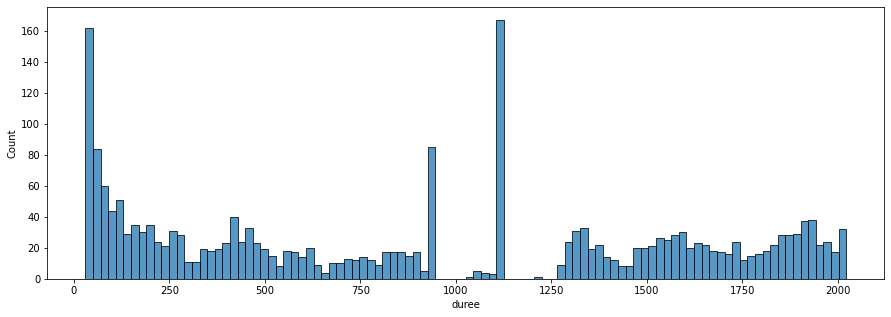

In [36]:
plt.figure(figsize=(15,5))
sns.histplot(data=ctx, x="duree", bins=100)

# on analyse les valeurs contenues dans le bloc B_
L'objectif est de n'avoir que des valeurs en lien avec les contentieux.

In [14]:
for c in ['B_streetnumber','B_streettype','B_address','B_address2','B_city',
          'B_state','B_zipcode','B_country','B_email','B_phone', 'contactnote']:
    print(c)
    print(adh_bloc_ctx[c].value_counts())
    print('---------------------------------------')

B_streetnumber
Series([], Name: B_streetnumber, dtype: int64)
---------------------------------------
B_streettype
Series([], Name: B_streettype, dtype: int64)
---------------------------------------
B_address
2023-01-14    95
2022-07-06    93
2021-10-22    86
2021-01-28    78
2021-08-10    75
              ..
2020-10-23     1
2020-08-21     1
2021-08-11     1
2020-09-05     1
2023-06-23     1
Name: B_address, Length: 164, dtype: int64
---------------------------------------
B_address2
message vocal        1582
usager joint          888
téléphone inconnu     721
Name: B_address2, dtype: int64
---------------------------------------
B_city
2023-01-25    26
2021-05-22    26
2021-07-27    26
2021-04-06    25
2022-05-21    25
              ..
2021-01-27     1
2022-07-06     1
2021-07-24     1
2021-02-03     1
2021-01-28     1
Name: B_city, Length: 143, dtype: int64
---------------------------------------
B_state
0           500
20210064      6
20220102      6
20220101      5
20220214      

On constate que 'B_streetnumber','B_streettype','B_email' et 'B_phone' ne contiennent aucune info, on peut donc les supprimer du dataframe.

In [15]:
adh_bloc_ctx = adh_bloc_ctx.drop(columns=['B_streetnumber','B_streettype','B_email', 'B_phone'])

In [16]:
adh_bloc_ctx

,borrowernumber,cardnumber,userid,B_address,B_address2,B_city,B_state,B_zipcode,B_country,contactnote,dateofbirth,branchcode,categorycode,dateenrolled,dateexpiry,date_due,contentieux
0,9.0,X0002058641,X0002058641,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2002-09-11,MED,BIBL,2007-05-02,2021-12-02,NaN,False
1,15.0,X0001920261,X0001920261,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009-09-08,MED,BIBL,2013-03-30,2021-09-29,NaN,False
2,25.0,X0002404233,X0002404233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1996-08-07,MED,BIBL,2009-07-17,2023-12-30,NaN,False
3,28.0,X0001659292,X0001659292,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007-12-21,MED,BIBL,2012-02-08,2022-09-18,NaN,False
4,42.0,X0002437651,X0002437651,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1970-10-23,MED,BIBL,2005-03-31,2021-08-18,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26485,73521.0,X0002747668,X0002747668,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006-10-07,MED,BIBL,2023-07-18,2024-07-18,NaN,False
26486,73522.0,X0002747101,X0002747101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1972-03-09,MED,BIBL,2023-07-18,2024-07-18,NaN,False
26487,73523.0,X0002747095,X0002747095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1997-06-07,MED,CSLT,2023-07-18,2024-07-18,NaN,False
26488,73524.0,X0002747040,X0002747040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-06-08,MED,BIBL,2023-07-18,2024-07-18,NaN,False


In [17]:
# ppur plus de facilité, on peut renommer les champs dédiés à la gestion des contentieux
adh_bloc_ctx = adh_bloc_ctx.rename(columns={"B_address":"date_appel_telephonique",
                              "B_address2":"resultat_appel",
                              "B_city":"date_demande_creation_tiers",
                              "B_state":"numero_titre_recette",
                              "B_zipcode":"numero_tiers_GF",
                              "B_country":"date_creation_titre_recette",
                              "contactnote":"documents_a_payer"})

In [18]:
adh_bloc_ctx

,borrowernumber,cardnumber,userid,date_appel_telephonique,resultat_appel,date_demande_creation_tiers,numero_titre_recette,numero_tiers_GF,date_creation_titre_recette,documents_a_payer,dateofbirth,branchcode,categorycode,dateenrolled,dateexpiry,date_due,contentieux
0,9.0,X0002058641,X0002058641,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2002-09-11,MED,BIBL,2007-05-02,2021-12-02,NaN,False
1,15.0,X0001920261,X0001920261,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009-09-08,MED,BIBL,2013-03-30,2021-09-29,NaN,False
2,25.0,X0002404233,X0002404233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1996-08-07,MED,BIBL,2009-07-17,2023-12-30,NaN,False
3,28.0,X0001659292,X0001659292,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007-12-21,MED,BIBL,2012-02-08,2022-09-18,NaN,False
4,42.0,X0002437651,X0002437651,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1970-10-23,MED,BIBL,2005-03-31,2021-08-18,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26485,73521.0,X0002747668,X0002747668,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006-10-07,MED,BIBL,2023-07-18,2024-07-18,NaN,False
26486,73522.0,X0002747101,X0002747101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1972-03-09,MED,BIBL,2023-07-18,2024-07-18,NaN,False
26487,73523.0,X0002747095,X0002747095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1997-06-07,MED,CSLT,2023-07-18,2024-07-18,NaN,False
26488,73524.0,X0002747040,X0002747040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-06-08,MED,BIBL,2023-07-18,2024-07-18,NaN,False


In [19]:
adh_bloc_ctx_with_data = adh_bloc_ctx[(~adh_bloc_ctx['date_appel_telephonique'].isna())
                                    | (~adh_bloc_ctx['resultat_appel'].isna())
                                    | (~adh_bloc_ctx['date_demande_creation_tiers'].isna())
                                    | (~adh_bloc_ctx['numero_titre_recette'].isna())
                                    | (~adh_bloc_ctx['numero_tiers_GF'].isna())
                                    | (~adh_bloc_ctx['date_creation_titre_recette'].isna())
                                    | (~adh_bloc_ctx['documents_a_payer'].isna())]
adh_bloc_ctx_with_data

,borrowernumber,cardnumber,userid,date_appel_telephonique,resultat_appel,date_demande_creation_tiers,numero_titre_recette,numero_tiers_GF,date_creation_titre_recette,documents_a_payer,dateofbirth,branchcode,categorycode,dateenrolled,dateexpiry,date_due,contentieux
8,72.0,X0002315447,X0002315447,2021-01-19,usager joint,2021-02-09,20210034,91611,2021-02-09,C0005382767\r\nC2500004195\r\nC2500012698\r\nC...,2012-04-05,MED,BIBL,2019-10-22,2021-06-22,2019-11-12,True
27,203.0,X0001954258,X0001954258,2021-02-06,message vocal,NaN,NaN,NaN,NaN,NaN,1998-08-04,MED,BIBL,2011-12-10,2023-05-07,NaN,False
30,212.0,X0002003986,X0002003986,2021-10-22,message vocal,NaN,NaN,NaN,NaN,NaN,2002-06-08,MED,BIBL,2013-10-02,2021-10-21,NaN,False
31,215.0,X0002094755,X0002094755,2023-05-17,usager joint,NaN,NaN,NaN,NaN,NaN,1980-08-29,MED,MEDB,2008-06-13,2023-08-26,NaN,False
32,237.0,X0002217536,X0002217536,NaN,NaN,NaN,NaN,NaN,2019-08-27,Titre émis avant 2021,2000-06-30,MED,BIBL,2011-05-06,2018-07-11,2018-02-24,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25663,72670.0,X0002654768,X0002654768,2023-04-04,message vocal,NaN,NaN,NaN,NaN,NaN,2016-03-31,MED,BIBL,2023-05-06,2024-05-06,2023-06-03,True
25728,72735.0,X0002609010,X0002609010,2023-05-03,message vocal,NaN,NaN,NaN,NaN,NaN,1973-05-09,MED,BIBL,2023-05-10,2024-05-10,NaN,False
25907,72914.0,X0002611129,X0002611129,NaN,NaN,NaN,NaN,92421,NaN,NaN,2016-05-26,MED,BIBL,2023-05-24,2024-05-24,NaN,False
25926,72933.0,X0002744513,X0002744513,2022-11-05,message vocal,2023-04-29,0,0,2023-04-29,C2500011914 - 10.95,2014-01-03,MED,BIBL,2023-05-25,2024-05-25,NaN,False


In [21]:
adh_bloc_ctx_with_data_pb[adh_bloc_ctx_with_data_pb['contentieux'] ==  False]

,borrowernumber,cardnumber,userid,date_appel_telephonique,resultat_appel,date_demande_creation_tiers,numero_titre_recette,numero_tiers_GF,date_creation_titre_recette,documents_a_payer,dateofbirth,branchcode,categorycode,dateenrolled,dateexpiry,date_due,contentieux


In [22]:
adh_bloc_ctx_with_data_pb.groupby("contentieux").size()

Series([], dtype: int64)

vérifier si pour ces cartes les colonnes contentieux peuvent être mises à Null

# Cartes avec données de contentieux sans contentieux

Explication de la requête ci dessous : 
* ligne 1 : `adh_bloc_ctx_with_data_without_ctx` = tous les documents de `adh_bloc_ctx_with_data` dont le `borrowernumber` ne correspond pas au borrowernumber des documents en contentieux qui ont une erreur de graphie (`adh_bloc_ctx_with_data_pb` )`adh_bloc_ctx_with_data_pb`)

a priori, données de contentieux à supprimer : attention à possibilité de faire des stats

In [25]:
data = {"B_address": None,
        "B_address2": None,
        "B_city": None,
        "B_state": None,
        "B_zipcode": None,
        "B_country": None,
        "contactnote": None}
userid = 'X0002525563'
mod_borrower(userid, data)

data={"B_address": null, "B_address2": null, "B_city": null, "B_state": null, "B_zipcode": null, "B_country": null, "contactnote": null}
X0002525563 : b'{\n   "modified_fields" : {},\n   "success" : true\n}\n'


In [52]:
query = """SELECT i.borrowernumber, DATE(i.date_due) as date_due, b.B_address2, b.B_state
FROM koha_prod.issues i
JOIN koha_prod.borrowers b ON b.borrowernumber = i.borrowernumber
WHERE i.date_due < CURDATE() - INTERVAL 1 DAY
AND b.categorycode IN ('BIBL', 'MEDA', 'MEDB','MEDC', 'CSVT')
ORDER BY i.date_due"""
retard = pd.read_sql(query, db_conn)

In [53]:
retard = retard.drop_duplicates(subset='borrowernumber')
retard['date_due'] = pd.to_datetime(retard['date_due'])
retard['retard_jours'] = (datetime.now() - retard['date_due']).dt.days

<AxesSubplot:xlabel='retard_jours', ylabel='Count'>

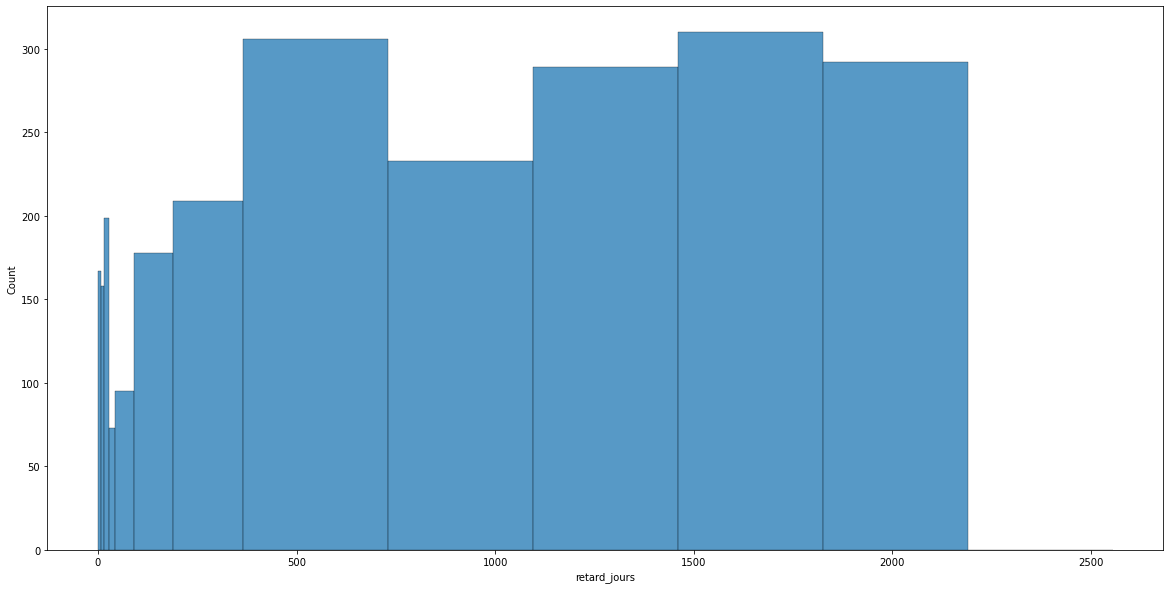

In [54]:
plt.figure(figsize=(20,10))
sns.histplot(data=retard[retard['retard_jours'] >= 1 ],
             x="retard_jours",
             log_scale = (False, False),
             bins=[0, 7, 14, 28, 42, 90, 190, 365, 730, 1095, 1460, 1825, 2190, 2555])

In [55]:
retard

,borrowernumber,date_due,B_address2,B_state,retard_jours
0,15475,2018-01-03,,,2101
2,23197,2018-01-03,,,2101
3,44282,2018-01-03,message vocal,,2101
6,45054,2018-01-04,,,2100
7,45190,2018-01-04,,,2100
...,...,...,...,...,...
7605,73093,2023-10-03,,,2
7606,73320,2023-10-03,,,2
7607,73455,2023-10-03,,,2
7612,73891,2023-10-03,,,2


In [58]:
r = retard['retard_jours']
tr = [0, 7, 14, 28, 42, 90, 180, 365, 730, 1095, 1460, 1825, 2190]
res = pd.cut(r,
             tr,
             labels=["Moins d'une semaine",
                     "D'une à deux semaines",
                     "De deux à quatre semaines",
                     "De quatre à six semaines",
                     "De six semaines à trois mois",
                     "De trois à 6 mois",
                     "De 6 mois à un an",
                     "De un à deux ans",
                     "De deux à trois ans",
                     "De trois à quatre ans",
                     "De quatre à cinq ans",
                     "De cinq à six ans"],
             include_lowest=True, right=False)
res















0         De cinq à six ans
2         De cinq à six ans
3         De cinq à six ans
6         De cinq à six ans
7         De cinq à six ans
               ...         
7605    Moins d'une semaine
7606    Moins d'une semaine
7607    Moins d'une semaine
7612    Moins d'une semaine
7617    Moins d'une semaine
Name: retard_jours, Length: 2509, dtype: category
Categories (12, object): ['Moins d'une semaine' < 'D'une à deux semaines' < 'De deux à quatre semaines' < 'De quatre à six semaines' ... 'De deux à trois ans' < 'De trois à quatre ans' < 'De quatre à cinq ans' < 'De cinq à six ans']

In [63]:
retard_enrichi = pd.merge(retard, res, left_index=True, right_index=True)

In [65]:
retard_enrichi = retard_enrichi.rename(columns={'B_address2': 'appel', 'B_state': 'titre_recette'})
retard_enrichi

,borrowernumber,date_due,appel,titre_recette,retard_jours_x,retard_jours_y
0,15475,2018-01-03,,,2101,De cinq à six ans
2,23197,2018-01-03,,,2101,De cinq à six ans
3,44282,2018-01-03,message vocal,,2101,De cinq à six ans
6,45054,2018-01-04,,,2100,De cinq à six ans
7,45190,2018-01-04,,,2100,De cinq à six ans
...,...,...,...,...,...,...
7605,73093,2023-10-03,,,2,Moins d'une semaine
7606,73320,2023-10-03,,,2,Moins d'une semaine
7607,73455,2023-10-03,,,2,Moins d'une semaine
7612,73891,2023-10-03,,,2,Moins d'une semaine


In [67]:
retard_enrichi.loc[retard_enrichi['titre_recette'] != '', 'titre_recette'] = True


In [73]:
retard_enrichi.groupby(['retard_jours_y', 'appel'])['borrowernumber'].count()

retard_jours_y                appel            
Moins d'une semaine                                149
                              message vocal          5
                              téléphone inconnu      0
                              usager joint           6
D'une à deux semaines                              132
                              message vocal          4
                              téléphone inconnu      1
                              usager joint           2
De deux à quatre semaines                          146
                              message vocal          5
                              téléphone inconnu      4
                              usager joint           6
De quatre à six semaines                            51
                              message vocal          3
                              téléphone inconnu      1
                              usager joint           1
De six semaines à trois mois                        24
                 

In [56]:
res.value_counts()

10 Cinq ans           310
07 Deux ans           306
11 Six ans            292
09 Quatre ans         289
08 Trois ans          233
06 Un an              222
02 Quatre semaines    199
00 Une semaine        167
05 Six mois           165
01 Deux semaines      158
04 Trois mois          95
03 Six semaines        73
Name: retard_jours, dtype: int64

In [51]:
query = """SELECT i.borrowernumber, DATE(i.date_due), DATE(i.returndate)
FROM koha_prod.issues i
JOIN koha_prod.borrowers b ON b.borrowernumber = i.borrowernumber
WHERE b.categorycode IN ('BIBL', 'MEDA', 'MEDB','MEDC', 'CSVT')
ORDER BY i.date_due"""
issues1401 = pd.read_sql(query, db_conn)
print(len(issues1401))
query = """SELECT i.borrowernumber, DATE(i.date_due), DATE(i.returndate)
FROM koha_prod.old_issues i
JOIN koha_prod.borrowers b ON b.borrowernumber = i.borrowernumber
WHERE b.categorycode IN ('BIBL', 'MEDA', 'MEDB','MEDC', 'CSVT')
ORDER BY i.date_due"""
issues1401b = pd.read_sql(query, db_conn)
print(len(issues1401b))
issues1401 = pd.concat([issues1401, issues1401b])
print(len(issues1401))

26710
98920
125630
